<a href="https://colab.research.google.com/github/Asifpatan05/Zidio-Time_Series_Analysis_with_Cryptocurrency/blob/main/Time_Series_Analysis_with_Cryptocurrency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# 1. Load Bitcoin data
btc = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
btc = btc[['Close']]
btc.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


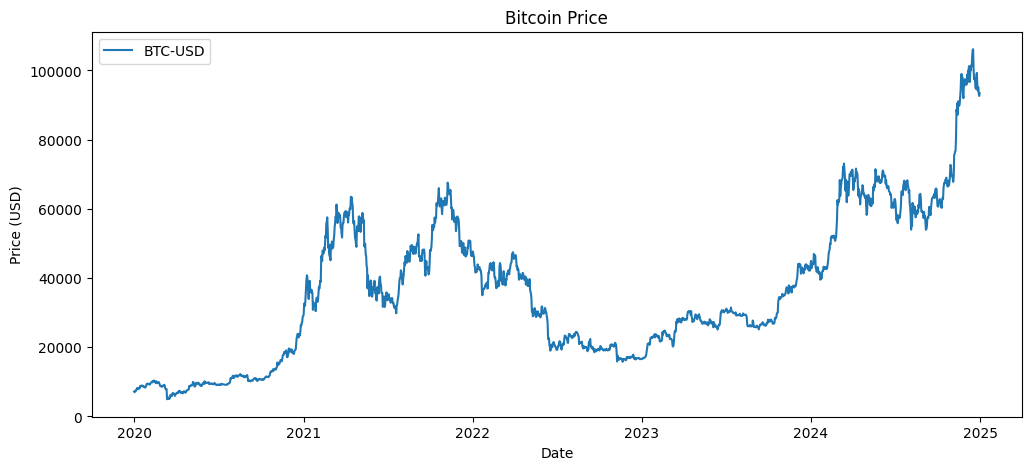

In [18]:
# 2. Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(btc, label='BTC-USD')
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [19]:
# 3. ARIMA Forecasting
model_arima = ARIMA(btc, order=(5,1,0))  # p,d,q can be tuned
arima_result = model_arima.fit()
arima_forecast = arima_result.forecast(steps=30)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


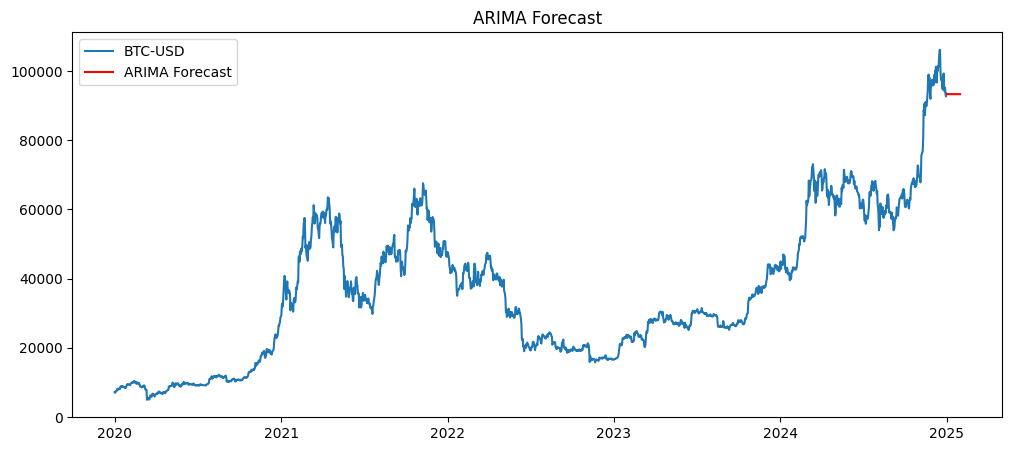

In [20]:
# Plot ARIMA Forecast
plt.figure(figsize=(12,5))
plt.plot(btc, label='BTC-USD')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

In [21]:
# 4. LSTM Forecasting
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(btc)

In [22]:
# Create sequences
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [23]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [24]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=64, verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0459
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0047
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0027
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0027
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0021
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0020
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0019
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0020
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0018
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0019


In [25]:
# Predict next 30 days
last_60 = scaled_data[-60:]
future_input = last_60.reshape(1, -1)
future_input = list(future_input[0])

In [26]:
future_predictions = []
for _ in range(30):
    if len(future_input) > 60:
        future_input = future_input[1:]
    input_data = np.array(future_input).reshape(1, time_step, 1)
    pred = model.predict(input_data, verbose=0)
    future_predictions.append(pred[0][0])
    future_input.append(pred[0][0])

In [27]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [28]:
# Plot LSTM Forecast
future_dates = pd.date_range(start=btc.index[-1] + pd.DateOffset(days=1), periods=30) # Removed closed='right' and started from the next day
forecast_df = pd.DataFrame(future_predictions, index=future_dates, columns=['LSTM Forecast'])

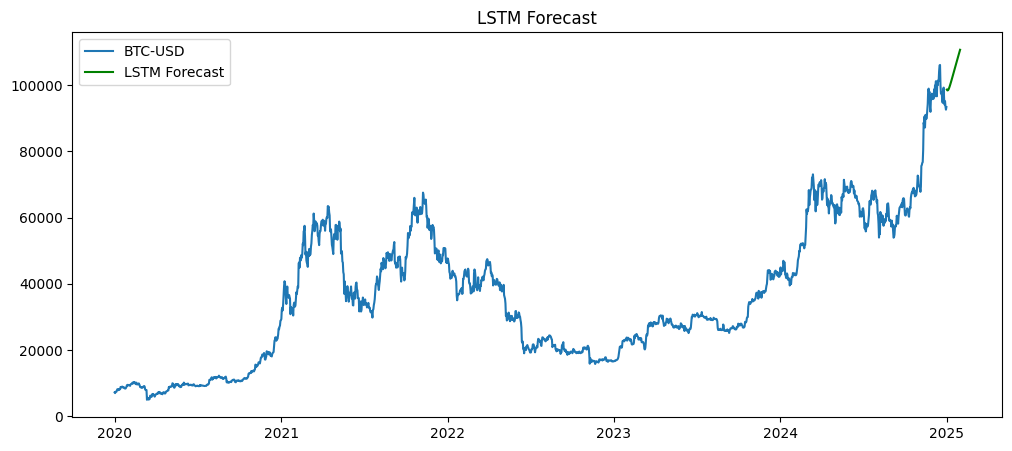

In [29]:
plt.figure(figsize=(12,5))
plt.plot(btc, label='BTC-USD')
plt.plot(forecast_df, label='LSTM Forecast', color='green')
plt.legend()
plt.title("LSTM Forecast")
plt.show()